# Model Training - Part 2

## Collaborative filtering

by: [Yachi Darji](https://www.linkedin.com/in/yachi-darji/)

### Import Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# for collaborative filtering

import os
import math
import random

from surprise import accuracy, Reader, Dataset, dump
from surprise import NormalPredictor, KNNBasic, SVD, SVDpp
from surprise.model_selection import cross_validate, GridSearchCV


In [2]:
rating=pd.read_csv("C:/Users/yachi/final/myproject/Data/ratings.csv")
book=pd.read_csv("C:/Users/yachi/final/myproject/Data/final_Data.csv")


where  :

* v=number of ratings(`rating_count`)
* m=minimum `ratings_count` required to be recommended
* R= average of ratings(`average_rating`)
* C=the mean ratings for all books

Now, let's determine the appropriate value for m, the number of votes needed to be listed in the chart. for this simple recommeder, our cutoff will be the 95th percentile. In order for a book to appear in the recommendation, it must recieve at least 95% of the other books on the list (around 2100 ratings).

In [3]:
def simple_recommender(book_data,n=5):
    v=book['ratings_count']
    m=book['ratings_count'].quantile(0.95)
    R=book['average_rating']
    C=book['average_rating'].mean()
    score=((v/(v+m))*R) + ((m/(v+m))*C)
    book['score']=score

    qualified=book.sort_values('score',ascending=False)
    return qualified[['book_id','title','authors','average_rating','ratings_count','score']].head(n)

In [4]:
simple_recommender(book)

,book_id,title,authors,average_rating,ratings_count,score
21,25,harry potter and the deathly hallows (harry po...,J.K. Rowling,4.61,1746574,4.555956
23,27,harry potter and the half-blood prince (harry ...,J.K. Rowling,4.54,1678823,4.490428
15,18,harry potter and the prisoner of azkaban (harr...,J.K. Rowling,4.53,1832823,4.485090
20,24,harry potter and the goblet of fire (harry pot...,J.K. Rowling,4.53,1753043,4.483227
1,2,harry potter and the sorcerer's stone (harry p...,J.K. Rowling,4.44,4602479,4.424365


This system offers generalized recommendations to every user based on popularity and average rating of the book. The recommender some flaws. For example, it makes the same suggestion to everyone, regardless of their own preferences. The top of our chart is full with J.K. Rowling's Harry Potter novels.

In order to personalize of our recommendations, we are going to create recommendation system that compares books based on a set of metrics and suggests books that are most similar to a particular book that a user liked.

### 3. Collaborative Filtering

This system suggests book to users based on past reading history and collaboration of other users' preferences. This recommender systems provides personalized recommendation. In this notebook, I will use [Surprise](https://surpriselib.com/) library to make the recommendation system. Surprise is a Python scikit for building and analyzing recommender systems that deal with explicit rating data. I will try to fit into 4 model and evaluate by using RMSE value. The model I use:
1. **Normal Predictor**
2. **KNN** (Memory-based)
3. **SVD** (Model-based)
4. **SVD++** (Model-based)

Since the calculation is taking to much memory, I dump the calculation file in order to reuse it for comparison. I will also test all the recommendation system to user 12874. This user is one of the user that give many ratings.

In [3]:
#to have reproducible experiments
my_seed = 0
random.seed(my_seed)
np.random.seed(my_seed)

#Load the full dataset
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(rating, reader)

#shuffle the ratings for unbiased result
all_ratings = data.raw_ratings
random.shuffle(all_ratings)

#split data into train and test data with the ratio 70:30
threshold = int(0.7 * len(all_ratings))
train_ratings = all_ratings[:threshold]
test_ratings = all_ratings[threshold:]

def book_read(user_id):
        '''Take user_id and return list of book that user has read'''
        books_list = list(book['book_id'])
        book_read_list = list(rating['book_id'][rating['user_id'] == user_id])
        return books_list, book_read_list

#### a. Normal Predictor

Algorithm predicting a random rating based on the distribution of the training set, which is assumed to be normal.

In [5]:
# prepare train data
data.raw_ratings = train_ratings

#select algorithm
npred = NormalPredictor()

In [6]:
%%time

#cross validation for train data
np_result = cross_validate(npred, data, measures=['RMSE'], cv=5, verbose=True, n_jobs=2)

Evaluating RMSE of algorithm NormalPredictor on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.3250  1.3240  1.3237  1.3237  1.3242  1.3241  0.0005  
Fit time          9.21    9.66    8.70    9.42    8.95    9.19    0.34    
Test time         15.18   14.21   14.80   14.47   13.55   14.44   0.55    
CPU times: total: 1min 54s
Wall time: 3min 42s


In order to make prediction on test data, we have to retrain whole train set first.

In [7]:
%%time
#retrain whole train test
trainset = data.build_full_trainset()
npred.fit(trainset)

# Compute RMSE on trainset (without fold)
np_train_pred = npred.test(trainset.build_testset())
print('Train RMSE:')
train_rmse = accuracy.rmse(np_train_pred)

#compute RMSE on testset
testset = data.construct_testset(test_ratings)
np_test_pred = npred.test(testset)
print('Test RMSE:')
test_rmse = accuracy.rmse(np_test_pred)

Train RMSE:
RMSE: 1.3233
Test RMSE:
RMSE: 1.3236
CPU times: total: 1min 34s
Wall time: 2min 55s


In [8]:
%%time

data.raw_ratings = all_ratings
npred.fit(data.build_full_trainset())

CPU times: total: 26.9 s
Wall time: 48.1 s


In [9]:
def get_recommendation_npred(user_id, n=5):
    '''Give n recommendation to user_id'''
    
    all_books, user_books =  book_read(user_id)
    next_books = [i for i in all_books if i not in user_books]
    
    if n <= len(next_books):
        ratings = []
        for i in next_books:
            est = npred.predict(user_id, i).est
            ratings.append((i, est))
        ratings = sorted(ratings, key=lambda x: x[1], reverse=True)
        book_ids = [id for id, rate in ratings[:n]]
        return book[book.book_id.isin(book_ids)][['book_id', 'title', 'authors', 'average_rating', 'ratings_count']]
    else:
        print('Please reduce your recommendation request')
        return

In [10]:
get_recommendation_npred(2)

,book_id,title,authors,average_rating,ratings_count
0,1,"the hunger games (the hunger games, #1)",Suzanne Collins,4.34,4780653
3,4,to kill a mockingbird,Harper Lee,4.25,3198671
14,17,"catching fire (the hunger games, #2)",Suzanne Collins,4.30,1831039
32,37,"the lion, the witch, and the wardrobe (chronic...",C.S. Lewis,4.19,1531800
33,38,the time traveler's wife,Audrey Niffenegger,3.95,746287


#### b. K-Nearest Neighbour


These are algorithms that are directly derived from a basic nearest neighbors approach.

In [28]:
#change data to trainset
data.raw_ratings = train_ratings 

#select algorithm
sim_options = {"name": "cosine",
               "user_based": False}
knn = KNNBasic(sim_options=sim_options)

In [29]:
%%time

#cross validation for train data
knn_result = cross_validate(knn, data, measures=['RMSE'], cv=5, verbose=True, n_jobs = 1)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8876  0.8883  0.8859  0.8878  0.8875  0.8874  0.0008  
Fit time          79.58   139.13  54.51   87.04   54.73   83.00   30.95   
Test time         184.65  128.23  205.05  122.46  114.13  150.90  36.73   
CPU times: total: 14min 4s
Wall time: 21min 10s


In [30]:
%%time

#retrain whole train test
trainset = data.build_full_trainset()
knn.fit(trainset)

# Compute RMSE on trainset (without fold)
knn_train_pred = knn.test(trainset.build_testset())
print('Train RMSE:')
train_rmse = accuracy.rmse(knn_train_pred)

#compute RMSE on testset
testset = data.construct_testset(test_ratings)
knn_test_pred = knn.test(testset)
print('Test RMSE:')
test_rmse = accuracy.rmse(knn_test_pred)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Train RMSE:
RMSE: 0.8001
Test RMSE:
RMSE: 0.8851
CPU times: total: 13min 37s
Wall time: 15min 15s


In [31]:
# uncomment this code to dump the calculation result for future use
# dump.dump('./dump_knn', knn_test_pred, knn)

In [32]:
%%time

data.raw_ratings = all_ratings
knn.fit(data.build_full_trainset())

Computing the cosine similarity matrix...
Done computing similarity matrix.
CPU times: total: 2min 47s
Wall time: 3min 23s


In [33]:
def get_recommendation_knn(user_id, n=5):
    '''Give n recommendation to user_id'''
    
    all_books, user_books =  book_read(user_id)
    next_books = [i for i in all_books if i not in user_books]
    
    if n <= len(next_books):
        ratings = []
        for i in next_books:
            est = knn.predict(user_id, i).est
            ratings.append((i, est))
        ratings = sorted(ratings, key=lambda x: x[1], reverse=True)
        book_ids = [id for id, rate in ratings[:n]]
        return book[book.book_id.isin(book_ids)][['book_id', 'title', 'authors', 'average_rating', 'ratings_count']]
    else:
        print('Please reduce your recommendation request')
        return

In [34]:
get_recommendation_knn(12874, 5)

,book_id,title,authors,average_rating,ratings_count
27,31,the help,Kathryn Stockett,4.45,1531753
89,98,"the girl who played with fire (millennium, #2)",Stieg Larsson,4.22,563994
103,114,tuesdays with morrie,Mitch Albom,4.06,556518
118,132,the five people you meet in heaven,Mitch Albom,3.90,449501
126,140,the girl who kicked the hornet's nest (millenn...,Stieg Larsson,4.20,443951


### c. Singular Value Decomposition (SVD)

The famous SVD algorithm, as popularized by Simon Funk during the Netflix Prize. SVD finds the latent factors associated with some matrix. SVD will decompose user-rating matrix into matrices that represents latent user-user features and item-item features.

In [12]:
#change data to trainset
data.raw_ratings = train_ratings 

#select algorithm
svd = SVD(random_state=0)

In [13]:
%%time

#cross validation for train data
svd_result = cross_validate(svd, data, measures=["RMSE"], cv=5, verbose=True, n_jobs = 2)



Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8505  0.8491  0.8501  0.8498  0.8510  0.8501  0.0006  
Fit time          104.64  104.84  104.52  103.85  88.28   101.23  6.48    
Test time         21.56   22.50   21.15   21.24   16.19   20.53   2.22    
CPU times: total: 2min
Wall time: 7min 13s


In [14]:
%%time

#retrain whole train test
trainset = data.build_full_trainset()
svd.fit(trainset)

# Compute RMSE on trainset (without fold)
svd_train_pred = svd.test(trainset.build_testset())
print('Train RMSE:')
train_rmse = accuracy.rmse(svd_train_pred)

#compute RMSE on testset
testset = data.construct_testset(test_ratings)
svd_test_pred = svd.test(testset)
print('Test RMSE:')
test_rmse = accuracy.rmse(svd_test_pred)

Train RMSE:
RMSE: 0.6441
Test RMSE:
RMSE: 0.8386
CPU times: total: 3min 17s
Wall time: 5min 58s


In [15]:
# uncomment this code to dump the calculation result for future use
dump.dump('./dump_svd', svd_test_pred, svd)

In [16]:
%%time

data.raw_ratings = all_ratings
svd.fit(data.build_full_trainset())

CPU times: total: 2min 7s
Wall time: 4min 30s


In [17]:
def get_recommendation_svd(user_id, n=5):
    '''Give n recommendation to user_id'''
    
    all_books, user_books =  book_read(user_id)
    next_books = [i for i in all_books if i not in user_books]
    
    if n <= len(next_books):
        ratings = []
        for i in next_books:
            est = svd.predict(user_id, i).est
            ratings.append((i, est))
        ratings = sorted(ratings, key=lambda x: x[1], reverse=True)
        book_ids = [id for id, rate in ratings[:n]]
        return book[book.book_id.isin(book_ids)][['book_id', 'title', 'authors', 'average_rating', 'ratings_count']]
    else:
        print('Please reduce your recommendation request')
        return

In [18]:
get_recommendation_svd(12874, 5)

,book_id,title,authors,average_rating,ratings_count
27,31,the help,Kathryn Stockett,4.45,1531753
194,215,ready player one,Ernest Cline,4.31,349423
226,250,wonder,R.J. Palacio,4.43,228538
390,425,go ask alice,Beatrice Sparks,3.77,196677
1698,1808,"morning star (red rising, #3)",Pierce Brown,4.50,47736


### d. SVD++

The singular value decomposition (SVD)++ algorithm is employed as an optimized SVD algorithm to enhance the accuracy of prediction by generating implicit feedback

In [19]:
#change data to trainset
data.raw_ratings = train_ratings 

#select algorithm
svdpp = SVDpp(random_state=0)

In [20]:
%%time

svdpp_result = cross_validate(svdpp, data, measures=["RMSE"], cv=5, verbose=True, n_jobs = 2)

Evaluating RMSE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8315  0.8321  0.8332  0.8340  0.8326  0.8327  0.0009  
Fit time          979.43  976.73  556.63  552.31  390.92  691.20  241.73  
Test time         172.67  170.39  142.70  145.46  95.43   145.33  27.83   
CPU times: total: 1min 42s
Wall time: 40min 12s


In [21]:
%%time

#retrain whole train test
trainset = data.build_full_trainset()
svdpp.fit(trainset)

# Compute RMSE on trainset (without fold)
svdpp_train_pred = svdpp.test(trainset.build_testset())
print('Train RMSE:')
train_rmse = accuracy.rmse(svdpp_train_pred)

#compute RMSE on testset
testset = data.construct_testset(test_ratings)
svdpp_test_pred = svdpp.test(testset)
print('Test RMSE:')
test_rmse = accuracy.rmse(svdpp_test_pred)

Train RMSE:
RMSE: 0.7085
Test RMSE:
RMSE: 0.8238
CPU times: total: 21min 26s
Wall time: 30min 52s


In [22]:
# uncomment this code to dump the calculation result for future use
# dump.dump('./dump_svdpp', svdpp_test_pred, svdpp)

In [23]:
%%time

data.raw_ratings = all_ratings
svdpp.fit(data.build_full_trainset())

CPU times: total: 25min 7s
Wall time: 39min 20s


In [26]:
def get_recommendation_svdpp(user_id, n=5):
    '''Give n recommendation to user_id'''
    
    all_books, user_books =  book_read(user_id)
    next_books = [i for i in all_books if i not in user_books]
    
    if n <= len(next_books):
        ratings = []
        for i in next_books:
            est = svdpp.predict(user_id, i).est
            ratings.append((i, est))
        ratings = sorted(ratings, key=lambda x: x[1], reverse=True)
        book_ids = [id for id, rate in ratings[:n]]
        return book[book.book_id.isin(book_ids)][['book_id', 'title', 'authors', 'average_rating', 'ratings_count']]
    else:
        print('Please reduce your recommendation request')
        return

In [27]:
get_recommendation_svdpp(12874, 5)

,book_id,title,authors,average_rating,ratings_count
27,31,the help,Kathryn Stockett,4.45,1531753
597,642,"world without end (the kingsbridge series, #2)",Ken Follett,4.23,128715
1243,1328,"i am pilgrim (pilgrim, #1)",Terry Hayes,4.23,49740
4310,4778,the holy bible: english standard version,Anonymous,4.66,17863
5302,5990,الطنطورية,Radwa Ashour,4.32,13931


### e. Evaluation

In [36]:
#uncomment this code to load the dump file
# np_test_pred, npred = dump.load('./dump_np')
# knn_test_pred, knn = dump.load('./dump_knn')
svd_test_pred, svd = dump.load('./dump_svd')
# svdpp_test_pred, svdpp = dump.load('./dump_svdpp')

In [37]:
#making the calculation reult into dataframe
df_np = pd.DataFrame(np_test_pred, columns=['uid', 'iid', 'rui', 'est', 'details'])
df_knn = pd.DataFrame(knn_test_pred, columns=['uid', 'iid', 'rui', 'est', 'details'])
df_svd = pd.DataFrame(svd_test_pred, columns=['uid', 'iid', 'rui', 'est', 'details'])  
df_svdpp = pd.DataFrame(svdpp_test_pred, columns=['uid', 'iid', 'rui', 'est', 'details'])

#### Comparing RMSE, Duration and Memory Use

In [38]:
data = [['NP', 1.3236, '2m 55s', 8.7], ['KNN', 0.8851, '15m 15s', 16], ['SVD', 0.8386, '5m 58s', 8.8],  ['SVD++', 0.8238, '30m 58s', 8.4]]
df = pd.DataFrame(data, columns=['Model', 'RMSE', 'Duration', 'Memory Use'])
df

,Model,RMSE,Duration,Memory Use
0,NP,1.3236,2m 55s,8.7
1,KNN,0.8851,15m 15s,16.0
2,SVD,0.8386,5m 58s,8.8
3,SVD++,0.8238,30m 58s,8.4


By comparing the metric evaluation of four model, we get the lowest RMSE in SVD++. However, although SVD++ shows lower RMSE results, it takes a very long time to do the calculations. If we look at the rating predictions, the distribution of ratings on SVD and SVD++ is not much different. 

**Why KNN took longer time to run?** <br>
The singular value decomposition (SVD)++ algorithm enhances the accuracy of prediction by generating implicit feedback so it takes considerably longer time to train, compared to the SVD.

**Why KNN requires lot of memory?** <br>
K-nearest neighbor (KNN) needs a lot of memory, since the recommendation systems rely on storing a sizable dataset of items and their properties in order to create suggestions. When a new item is added or a recommendation is needed, the KNN method must scan the entire dataset to discover the closest neighbors, which can be computationally intensive and demand a lot of memory.

#### Comparing Prediction Distribution

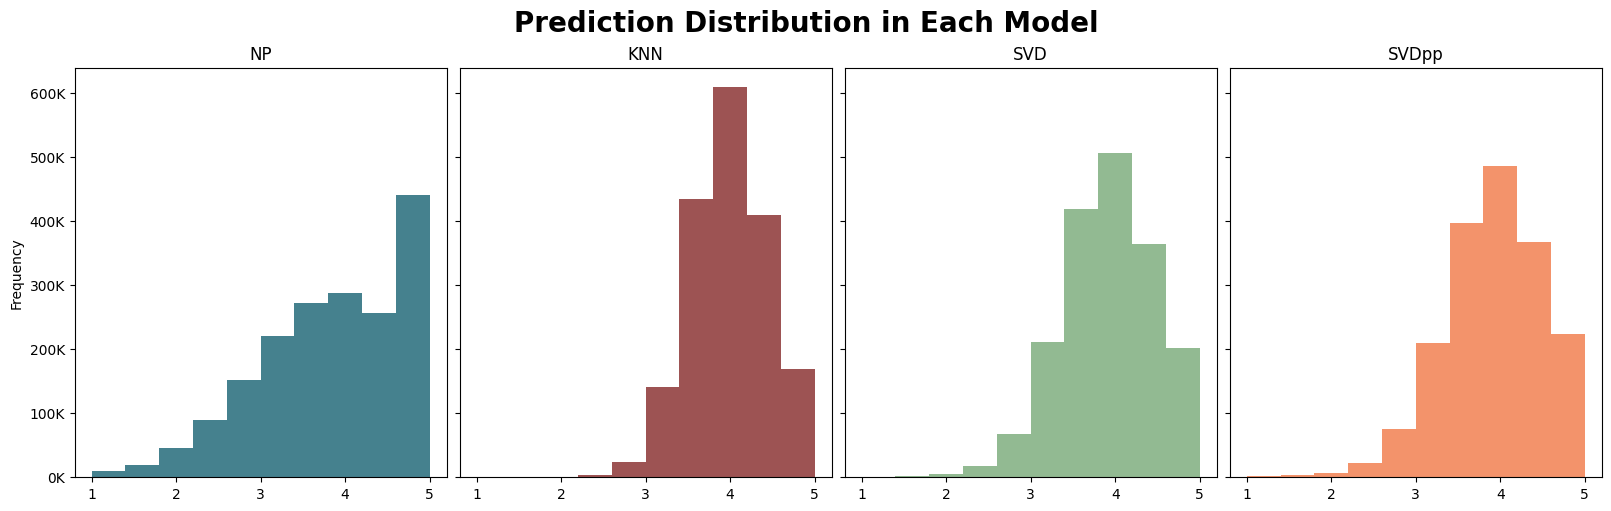

In [41]:
# Count the number of predictions for each rating value
figure, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4,  figsize=(16, 5), sharey=True, constrained_layout=True)
df_np.est.plot(kind='hist', title='NP', ax=ax1, color='#45818E')
df_knn.est.plot(kind='hist', title='KNN', ax=ax2, color='#9D5353')
df_svd.est.plot(kind='hist', title='SVD', ax=ax3, color='#92BA92')
df_svdpp.est.plot(kind='hist', title='SVDpp', ax=ax4, color='#F3936B')
current_values = plt.gca().get_yticks() / 1000
plt.gca().set_yticklabels(['{:,.0f}'.format(x) + 'K' for x in current_values])
plt.suptitle('Prediction Distribution in Each Model', weight='bold', fontsize=20)
plt.show()

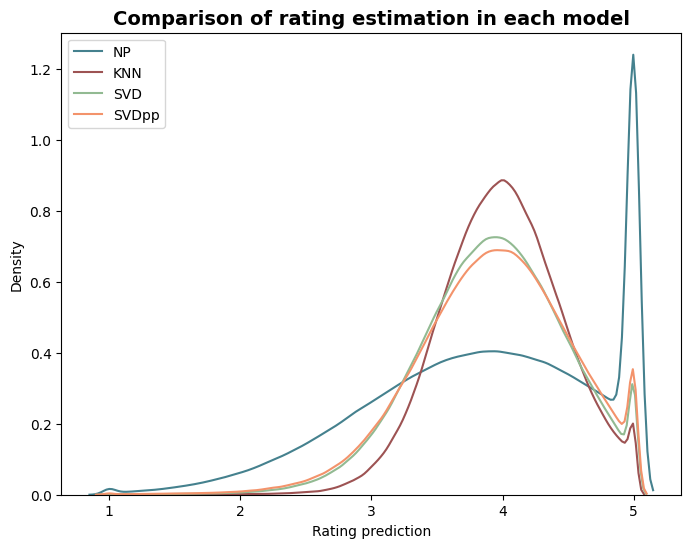

In [42]:
fig, ax = plt.subplots(figsize=(8,6))
sns.kdeplot(df_np['est'], shade=False, color='#45818E', label = 'NP', ax=ax)
sns.kdeplot(df_knn['est'], shade=False, color='#9D5353', label = 'KNN', ax=ax)
sns.kdeplot(df_svd['est'], shade=False, color='#92BA92', label = 'SVD', ax=ax)
sns.kdeplot(df_svdpp['est'], shade=False, color='#F3936B', label = 'SVDpp', ax=ax)
ax.legend()
plt.xlabel('Rating prediction')
plt.ylabel('Density')
plt.title('Comparison of rating estimation in each model', weight='bold', fontsize=14)
plt.show()

As we can see, Normal Predictor model predicts higher ratings more often, meanwhile KNN predictions are concentrated around the mean. For SVD and SVD++, the ratings are more fairly distributed.

Based on our comparison, we choose SVD as the best model. SVD was chosen because it has a relatively low RMSE value, relatively short processing time and the memory used is not too large.<br>
To tune the hyperparameter, we can utilize grid search, an optimization technique that explores all possibilities of the provided hyperparameter options. The parameters that will be tuned are:
- n_epochs: the number of iterations of the SGD procedure
- lr_all: the learning rate for all parameters
- reg_all: the regularization term for all parameters

In [43]:
# prepare train data
data.raw_ratings = train_ratings

AttributeError: 'list' object has no attribute 'raw_ratings'

In [ ]:
%%time

grid = {'n_epochs': [20, 30], 
        'lr_all': [.005, .001], 
        'reg_all': [0.02, 0.04]} 

gs = GridSearchCV(SVD, grid, measures=['RMSE'], cv=5, n_jobs=2)
gs.fit(data)

print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

In [ ]:
#select best algorithm
svdtuned = gs.best_estimator['rmse']

In [ ]:
%%time

#retrain whole train test (without fold)
trainset = data.build_full_trainset()
svdtuned.fit(trainset)

# Compute RMSE on trainset (without fold)
svdtuned_train_pred = svdtuned.test(trainset.build_testset())
print('Train RMSE:')
train_rmse = accuracy.rmse(svdtuned_train_pred)

#compute RMSE on testset
testset = data.construct_testset(test_ratings)
svdtuned_test_pred = svdtuned.test(testset)
print('Test RMSE:')
test_rmse = accuracy.rmse(svdtuned_test_pred)

In [ ]:
%%time

data.raw_ratings = all_ratings
svdtuned.fit(data.build_full_trainset())

In [ ]:
def get_recommendation(user_id, n=5):
    '''Give n recommendation to user_id'''
    
    all_books, user_books =  book_read(user_id)
    next_books = [book for book in all_books if book not in user_books]
    
    if n <= len(next_books):
        ratings = []
        for book in next_books:
            est = svdtuned.predict(user_id, book).est
            ratings.append((book, est))
        ratings = sorted(ratings, key=lambda x: x[1], reverse=True)
        book_ids = [id for id, rate in ratings[:n]]
        return b[b.book_id.isin(book_ids)][['book_id', 'title', 'authors', 'average_rating', 'ratings_count']]
    else:
        print('Please reduce your recommendation request')
        return

In [ ]:
get_recommendation(12874, 5)

In [ ]:
# uncomment this code to dump the calculation result for future use
dump.dump('./dump_tuning', svdtuned_test_pred, svdtuned)

In [ ]:
# uncomment this code to load the dump file
svd_test_pred, svd = dump.load('./dump_svd')
svdtuned_test_pred, svdtuned = dump.load('./dump_tuning')

In [44]:
df_svd = pd.DataFrame(svd_test_pred, columns=['uid', 'iid', 'rui', 'est', 'details'])
df_svdtuned = pd.DataFrame(svdtuned_test_pred, columns=['uid', 'iid', 'rui', 'est', 'details'])

NameError: name 'svdtuned_test_pred' is not defined

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
sns.kdeplot(df_svd['est'], shade=False, color='#92BA92', label = 'SVD', ax=ax)
sns.kdeplot(df_svdtuned['est'], shade=False, color='#DEBA9D', label = 'Tuned SVD', ax=ax)
ax.legend()
plt.xlabel('Rating prediction')
plt.ylabel('Density')
plt.title('Comparison of rating estimation in SVD and Tuned SVD')
plt.show()

Rating prediction around the mean is higher in tuned SVD. This is probably as a result of higher reg_all, so the parameter are regularized.

## Conclusion

1. **Simple Recommender** <br>
Like the name suggests, this model offers the simple recommendation.  This model does not provide user-spesific recommendations but suitable for new user (have no cold-start problem). Cold problem refers to a problem when the system is unable to draw any conclusions about users or objects because it has not yet acquired enough data.


2. **Content based filtering** <br>
Recommendations based on title, authors, description, and genre using cosine similarity have been made. To provide a balance of book recommendations, an additional popularity-rating filter has been added. This method is suitable for people who are looking for books that are similar to their favorite books, but this system cannot capture tastes and provide recommendations across genres.
By applying a content based model, instead of having to rate 30 books to start the recommendation engine, users can just pick one book they liked for Goodreads to provide good recommendations for new users, making the process easier.


3. **Collaborative Filtering**<br>
By using Surprise library, I tried building a recommender with 4 algorithms: Normal Predictor, KNN, SVD, and SVD++. SVD is suitable for making a recommendation system in Goodreads because of its lower RMSE, faster calculation and lower memory requirement unlike KNN. I think the RMSE value of 0.8 is still quite reasonable for a Goodreads rating.<br>
Notice that Collaborative filtering doesn’t require features about the items or users to be known. We can only use rating data. However, this recommendation system need prior data and suffers cold start problem, for example when new user or new book added to the list. 